In [1]:
import numpy as np
import torch
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
import math
from math import pi

In [2]:
import surface_normalize

In [3]:
film = np.zeros((200, 200, 100))

bottom = 10
film[:, :, 0:bottom] = 10 # bottom

height = 60
left_side = 75
right_side = 75
film[left_side:200-left_side, left_side:200-left_side, 0:height] = 10

In [4]:
testpy = surface_normalize.surface_normal(center_with_direction=np.array([[100,100,50], [100, 100, 0]]), range3D=np.array([[0, 100, 0, 100, 10, 100], [0, 100, 0, 100, 0, 10]]), InOrOut=[1, 1])

In [5]:
getdata = testpy.get_pointcloud(film)

100
torch.Size([49401, 3])


In [6]:
print(getdata.shape)

(49401, 6)


In [64]:
def get_reflect_rate(plane, pos, vel):
    # plane = self.get_pointcloud(film)
    plane_point = plane[:, 3:6]
    normal = plane[:, :3]
    velocity_normal = np.linalg.norm(vel, axis=1)
    velocity = np.divide(vel.T, velocity_normal).T
    plane_tree = KDTree(plane_point)

    dd, ii = plane_tree.query(pos, k=1, workers=1)
    # print(dd, ii, sep='\n')
    print(normal[ii].shape)
    print(normal[ii])
    # theta = normal[ii]
    print(velocity)
    print(normal[ii].shape)
    dot_products = np.einsum('...i,...i->...', velocity, normal[ii])
    theta = np.arccos(dot_products)
    return theta

In [6]:
pos = np.array([[51, 51, 8.5],[51, 51, 8.5]])
vel = np.array([[0, 0.1, 1.3],[0, 0, 1.3]])

get_rate = testpy.get_inject_theta(getdata, pos, vel)

In [7]:
print(get_rate)
print(get_rate.shape)

[0.07677189 0.        ]
(2,)


In [8]:
get_theta = testpy.compare_theta(get_rate)
print(get_theta)

[1.00883659 1.        ]


In [68]:
a = np.array([  0,   pi/18,   pi/9,   pi/6,   2*pi/9,   5*pi/18,   pi/3,   7*pi/18,   4*pi/9, pi/2])
c = 0.34*pi

hist = np.histogram(c, a)
print(hist)

(array([0, 0, 0, 0, 0, 0, 1, 0, 0], dtype=int64), array([0.        , 0.17453293, 0.34906585, 0.52359878, 0.6981317 ,
       0.87266463, 1.04719755, 1.22173048, 1.3962634 , 1.57079633]))


In [3]:
from scipy import interpolate

In [4]:
yield_hist = np.array([[1.0, 1.05,  1.2,  1.4,  1.5, 1.07, 0.65, 0.28, 0.08,  0], \
                            [  0,   pi/18,   pi/9,   pi/6,   2*pi/9,   5*pi/18,   pi/3,   7*pi/18,   4*pi/9, pi/2]])

yield_func = interpolate.interp1d(yield_hist[1], yield_hist[0], kind='quadratic')

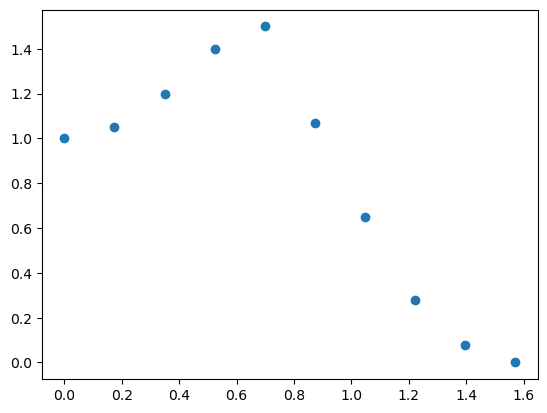

In [15]:
xnew = np.arange(0, pi/2, 0.01)
xnew = np.array([])
ynew = yield_func(xnew)   # use interpolation function returned by `interp1d`
plt.plot(yield_hist[1], yield_hist[0], 'o', xnew, ynew, '-')
plt.show()

In [19]:
xnew = np.array([0])
print(xnew.size)
print(ynew.size)

1
0


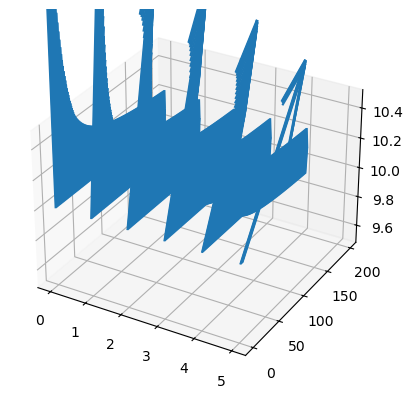

In [7]:
ax = plt.figure().add_subplot(projection='3d')
for i in range(1000):
    # ax.scatter(getdata[i,,getdata[i,1],getdata[i,2], facecolors='none',edgecolors = 'c')
    ax.quiver(getdata[i,3],getdata[i,4],getdata[i,5], \
              getdata[i,3]+getdata[i,3],getdata[i,4]+getdata[i,1],getdata[i,5]+getdata[i,2], length=2, normalize=True)

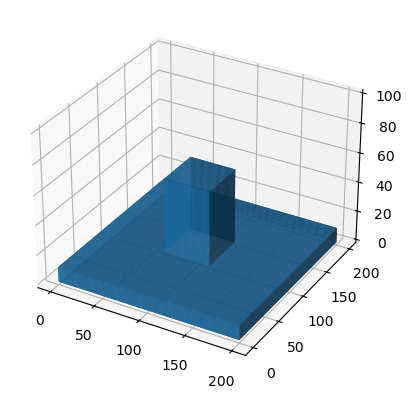

In [3]:
indice_wall = np.array(film == 10)
# in_depo = np.logical_and(result > 0, result < 1)
# and plot everything
ax = plt.figure().add_subplot(projection='3d')
# ax.voxels(surface_depo, edgecolor='k')
ax.voxels(indice_wall)
# ax.voxels(in_depo)

plt.show()

In [4]:
def scanZ(film):
    xshape = film.shape[0]
    yshape = film.shape[1]
    zshape = film.shape[2]
    surface_sparse = torch.zeros((xshape, yshape, zshape))
    print(zshape)
    for i in range(zshape-1):
        for j in range(xshape-1):
            for k in range(yshape-1):
                if (film[j, k, i] == 0 and film[j, k, i-1] != 0) or (film[j, k, i] == 0 and film[j, k, i+1] != 0) \
                or (film[j, k, i] == 0 and film[j-1, k, i] != 0) or (film[j, k, i] == 0 and film[j+1, k, i] != 0) \
                or (film[j, k, i] == 0 and film[j, k-1, i] != 0) or (film[j, k, i] == 0 and film[j, k+1, i] != 0):
                    surface_sparse[j,k,i] = 1
    return surface_sparse.to_sparse()

In [5]:
def scanZ2(film):
    xshape, yshape, zshape = film.shape
    
    # 初始化一个全零的表面稀疏张量
    surface_sparse = torch.zeros((xshape, yshape, zshape))
    
    # 获取当前平面与前后平面的布尔索引
    current_plane = film == 0
    prev_plane = torch.zeros_like(film)
    next_plane = torch.zeros_like(film)
    
    prev_plane[:, :, 1:] = film[:, :, :-1]
    next_plane[:, :, :-1] = film[:, :, 1:]
    
    # 获取周围邻居的布尔索引
    neighbors = torch.zeros_like(film, dtype=torch.bool)
    
    neighbors[1:, :, :] |= film[:-1, :, :] != 0  # 上面
    neighbors[:-1, :, :] |= film[1:, :, :] != 0  # 下面
    neighbors[:, 1:, :] |= film[:, :-1, :] != 0  # 左边
    neighbors[:, :-1, :] |= film[:, 1:, :] != 0  # 右边
    neighbors[:, :, 1:] |= film[:, :, :-1] != 0  # 前面
    neighbors[:, :, :-1] |= film[:, :, 1:] != 0  # 后面
    
    # 获取满足条件的索引
    condition = (current_plane & (prev_plane != 0)) | (current_plane & (next_plane != 0)) | (current_plane & neighbors)
    
    # 更新表面稀疏张量
    surface_sparse[condition] = 1
    
    return surface_sparse.to_sparse()


In [10]:
from timeit import Timer
t = Timer(lambda: (scanZ(film)))
print(t.timeit(number=1))

100
10.369212599998718


In [12]:
film = torch.Tensor(film)

In [13]:
t = Timer(lambda: (scanZ2(film)))
print(t.timeit(number=1))

0.14592609999999695


In [ ]:
test = scanZ(film)
testplt = test.to_dense()

In [4]:
def normalconsistency_3D_real(planes):
    
    """
    
    This function checks wherer the normals are oriented towards the outside of the surface, i.e., it 
    checks the consistency of the normals.
    The function changes the direction of the normals that do not point towards the outside of the shape
    The function checks whether the normals are oriented towards the centre of the ellipsoid, 
    and if YES, then, it turns their orientation
    
    INPUTS:
        planes: Vector N x 6, where M is the number of points whose normals and 
        centroid have been calculated. the columns are the coordinates of the normals and the centroids
        
    OUTPUTS:
        planesconsist: N x 6 array, where N is the number of points whose planes have been calculated. This array 
        has all the planes normals pointing outside the surface.
        
    """
    
    nbnormals = np.size(planes, 0)
    planes_consist=np.zeros((nbnormals,6))
    planes_consist[:, 3:6] = planes[:, 3:6] # We just copy the columns corresponding to the coordinates of the centroids (from 3th to 5th)
    
    """ Try the atan2 function : https://uk.mathworks.com/help/vision/ref/pcnormals.html#buxdmoj"""
    
    # sensorcentre=np.array([0,0,0])
    sensorcentre=np.array([100,100,0]) # vertax shape
    for i in range(nbnormals):
    
        p1 = (sensorcentre - planes[i,3:6]) / np.linalg.norm(sensorcentre - planes[i,3:6]) # Vector from the centroid to the centre of the ellipsoid (here the sensor is placed)
        p2 = planes[i,0:3]
        
        angle = math.atan2(np.linalg.norm(np.cross(p1,p2)), np.dot(p1,p2) ) # Angle between the centroid-sensor and plane normal
       
        
        if (angle >= -pi/2 and angle <= pi/2): # (angle >= -pi/2 and angle <= pi/2):
            
            planes_consist[i,0] = -planes[i,0]
            planes_consist[i,1] = -planes[i,1]
            planes_consist[i,2] = -planes[i,2]  
            
        else:
            
            planes_consist[i,0] = planes[i,0]
            planes_consist[i,1] = planes[i,1]
            planes_consist[i,2] = planes[i,2]
         
    return planes_consist

In [5]:
test = scanZ(film)
testplt = test.to_dense()

100


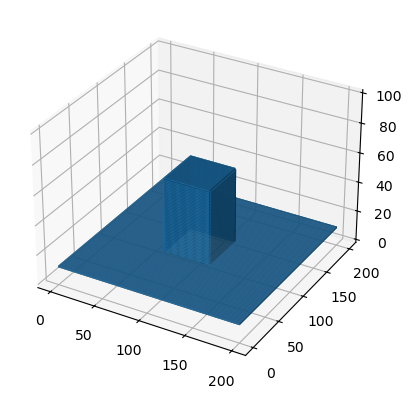

In [14]:
test = scanZ2(film)
testplt = test.to_dense()
# print(testplt)
indice_wall = np.array(testplt == 1)
# in_depo = np.logical_and(result > 0, result < 1)
# and plot everything
ax = plt.figure().add_subplot(projection='3d')
# ax.voxels(surface_depo, edgecolor='k')
ax.voxels(indice_wall)
# ax.voxels(in_depo)

plt.show()

100


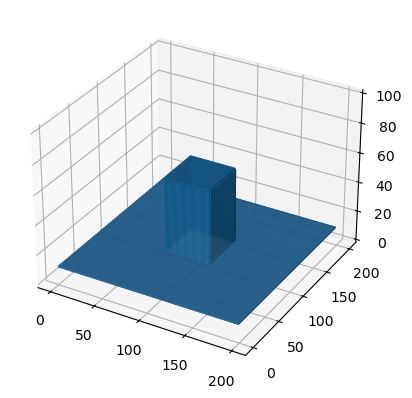

In [5]:
test = scanZ(film)
testplt = test.to_dense()
# print(testplt)
indice_wall = np.array(testplt == 1)
# in_depo = np.logical_and(result > 0, result < 1)
# and plot everything
ax = plt.figure().add_subplot(projection='3d')
# ax.voxels(surface_depo, edgecolor='k')
ax.voxels(indice_wall)
# ax.voxels(in_depo)

plt.show()

In [6]:
points = test.indices().T
print(points.shape)

surface_tree = KDTree(points)
dd, ii = surface_tree.query(points, k=10, workers=1)

pointsNP = points.numpy()


normal_all = np.zeros((ii.shape[0], 3))
for i in range(ii.shape[0]):
    knn_pt = pointsNP[ii[i]]
    # print(knn_pt.shape)
    # xmn = np.mean(knn_pt[:,0], axis=1)
    # ymn = np.mean(knn_pt[:,1], axis=1)
    # zmn = np.mean(knn_pt[:,2], axis=1)
    xmn = np.mean(knn_pt[:,0])
    ymn = np.mean(knn_pt[:,1])
    zmn = np.mean(knn_pt[:,2])

    c=np.zeros((np.size(knn_pt,0),3))

    c[:,0] = knn_pt[:,0]-xmn
    c[:,1] = knn_pt[:,1]-ymn
    c[:,2] = knn_pt[:,2]-zmn

    cov=np.zeros((3,3))    

    cov[0,0] = np.dot(c[:,0],c[:,0])
    cov[0,1] = np.dot(c[:,0],c[:,1])
    cov[0,2] = np.dot(c[:,0],c[:,2])

    cov[1,0] = cov[0,1]
    cov[1,1] = np.dot(c[:,1],c[:,1])
    cov[1,2] = np.dot(c[:,1],c[:,2])

    cov[2,0] = cov[0,2]
    cov[2,1] = cov[1,2]
    cov[2,2] = np.dot(c[:,2],c[:,2])

    "Single value decomposition (SVD)"

    u,s,vh = np.linalg.svd(cov) # U contains the orthonormal eigenvectors and S contains the eigenvectors

    "Selection of minimum eigenvalue"

    minevindex = np.argmin(s)

    "Selection of orthogonal vector corresponing to this eigenvalue --> vector normal to the plane defined by the kpoints"

    normal_vect = u[:,minevindex]
    normal_all[i, :] = normal_vect


planes=np.zeros((points.shape[0],6))
for i in range(points.shape[0]):

    planes[i,0:3] = normal_all[i] #Keep the coordinates of the normal vectors
    planes[i,3:6] = pointsNP[i] #Keep the coordinates of the centroid

planes_consist = normalconsistency_3D_real(planes)

torch.Size([49401, 3])


In [18]:
planes_consist.shape

(49401, 6)

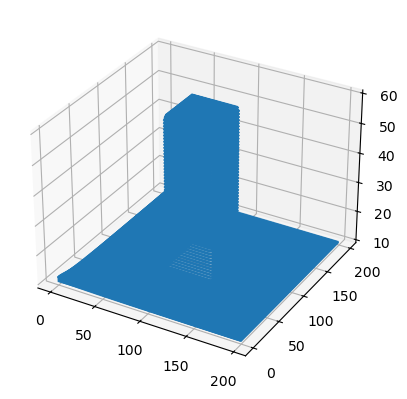

In [12]:
ax = plt.figure().add_subplot(projection='3d')
for i in range(points.shape[0]):
    # ax.scatter(planes_consist[i,0],planes_consist[i,1],planes_consist[i,2], facecolors='none',edgecolors = 'c')
    ax.quiver(planes_consist[i,3],planes_consist[i,4],planes_consist[i,5], \
              planes_consist[i,3]+planes_consist[i,0],planes_consist[i,4]+planes_consist[i,1],planes_consist[i,5]+planes_consist[i,2], length=2, normalize=True)